# Project dataframe construction template and example
Let's start by reminding ourselves about the data we had.

In [1]:
!aws s3 ls source-image-350

2020-10-20 22:27:43    1246635 emoryID-edited.jpg


In [2]:
!aws s3 ls target-image-350

2020-10-20 22:32:57    5200897 00100sPORTRAIT_00100_BURST20190410214954518_COVER.jpg
2020-10-20 22:31:15     884526 00100sPORTRAIT_00100_BURST20191120191036957_COVER.jpg
2020-10-20 22:31:23    4595103 00100sPORTRAIT_00100_BURST20191120191321645_COVER.jpg
2020-10-20 22:31:14    4498506 00100sPORTRAIT_00100_BURST20191120191425564_COVER.jpg
2020-10-20 22:31:06    4418469 00100sPORTRAIT_00100_BURST20191120191450371_COVER.jpg
2020-10-20 22:30:57    4213703 00100sPORTRAIT_00100_BURST20191120191544633_COVER.jpg
2020-10-20 22:30:50    4359770 00100sPORTRAIT_00100_BURST20191120191624298_COVER.jpg
2020-10-20 22:30:42    4270253 00100sPORTRAIT_00100_BURST20191120191626637_COVER.jpg
2020-10-20 22:29:35     988225 00100sPORTRAIT_00100_BURST20200311104551150_COVER.jpg
2020-10-20 22:33:23     660883 20170311_081108.jpg
2020-10-20 22:33:26    1535989 20170311_144831.jpg
2020-10-20 22:33:22    1650552 20170311_144836.jpg
2020-10-20 22:33:24     363731 IMG_0077.jpg
2020-10-20 22:33:19     582670 IMG_069

## Viewing the pictures in the notebook
For this we need open the file directly from S3 and then display that image file.
To open a file from S3 we use `s3fs`.

In [3]:
import s3fs
fs = s3fs.S3FileSystem()

In [5]:
file = fs.open('s3://source-image-350/emoryID-edited.jpg')

Next, we need to display this open file. We import a library for working with photos in Python called PIL.

In [61]:
from PIL import Image

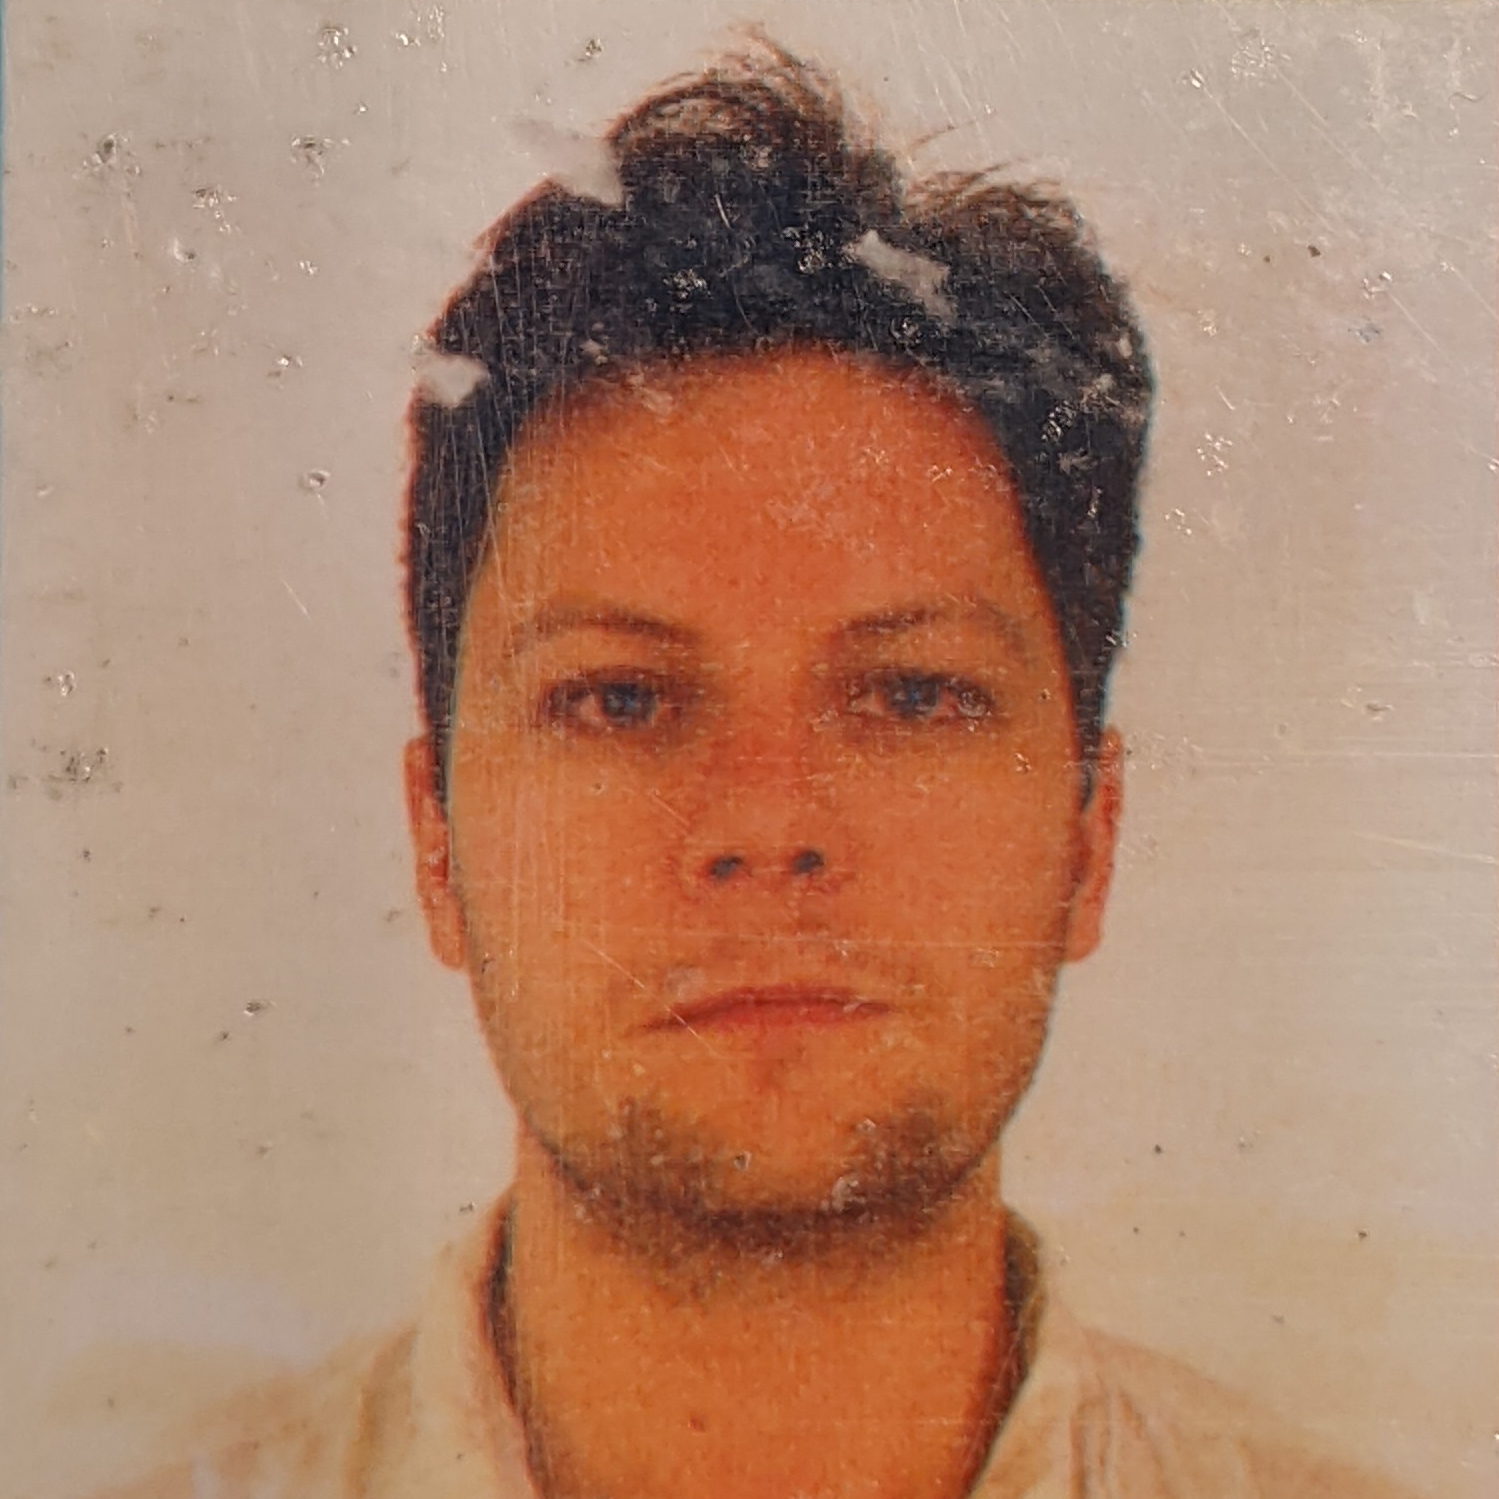

In [7]:
image = Image.open(file)
display(image)

Let's try to resize the image.

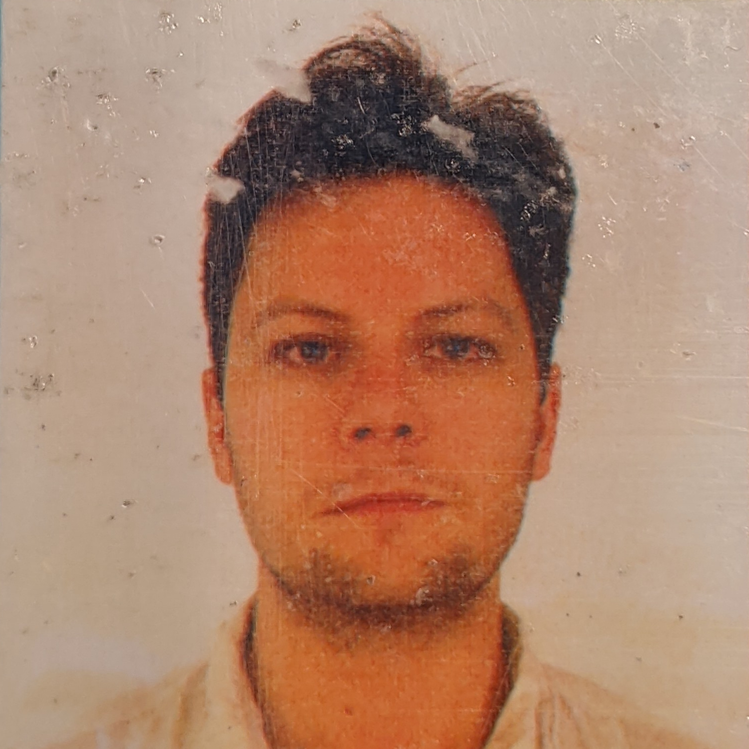

In [8]:
# Provide the target width and height of the image
(width, height) = (image.width // 2, image.height // 2)
im_resized = image.resize((width, height))
display(im_resized)

Let's write a Python function that return the similarity score of a given photo, that is, how similar Rekognition thinks the input photo is to the reference photo.

In [9]:
import boto3
import numpy as np

In [10]:
client = boto3.client('rekognition')

In [11]:
def extract_similarity(photo):
    try:
        comparison = client.compare_faces(
            SourceImage= {'S3Object':{'Bucket':'source-image-350', 'Name':'emoryID-edited.jpg'}},
            TargetImage = {'S3Object':{'Bucket':'target-image-350','Name':photo}})
        similarity = comparison['FaceMatches'][0]['Similarity']
    except Exception:
        similarity = np.nan
    return similarity

Let's test it on a photo.

In [12]:
photo = '00100sPORTRAIT_00100_BURST20190410214954518_COVER.jpg'
extract_similarity(photo)

99.8214340209961

## Obtaining picture metadata
Using `PIL` we will obtain more information about each picture.

In [13]:
file2 = fs.open('s3://target-image-350/00100sPORTRAIT_00100_BURST20190410214954518_COVER.jpg')
image2 = Image.open(file2)

In [14]:
exifdata = image2.getexif()

In [15]:
exif_data_dict = dict(exifdata)
exif_data_dict

{36864: b'0220',
 37121: b'\x01\x02\x03\x00',
 37377: 6.53,
 36867: '2019:04:10 21:49:54',
 36868: '2019:04:10 21:49:54',
 37378: 1.7,
 37379: 3.28,
 37380: 0.0,
 37381: 1.7,
 37382: 1.239,
 37383: 2,
 37385: 16,
 37386: 2.97,
 40961: 1,
 40962: 3264,
 41990: 0,
 37520: '568040',
 37521: '568040',
 37522: '568040',
 40963: 2448,
 41996: 2,
 257: 2448,
 271: 'Google',
 41495: 2,
 272: 'Pixel 3 XL',
 274: 8,
 33434: 0.010823,
 40965: 20601,
 282: 72.0,
 33437: 1.8,
 41729: b'\x01',
 283: 72.0,
 34850: 2,
 34853: {0: b'\x02\x02\x00\x00',
  1: 'N',
  2: (37.0, 46.0, 24.342),
  3: 'W',
  4: (122.0, 23.0, 20.935),
  5: b'\x01',
  6: 41.144,
  7: (4.0, 45.0, 55.0),
  11: 20.368,
  27: b'ASCII\x00\x00\x00fused',
  29: '2019:04:11'},
 41985: 1,
 34855: 96,
 296: 2,
 41986: 0,
 40960: b'0100',
 256: 3264,
 41987: 0,
 305: 'HDR+ 1.0.239730035zp',
 306: '2019:04:10 21:49:54',
 41988: 0.0,
 41989: 28,
 41992: 0,
 41993: 0,
 41994: 0,
 34665: 245,
 531: 1,
 37500: b'HDRP\x02\xefd5m^p\x1e,\xea\xe3LWV

In [20]:
from PIL.ExifTags import TAGS

In [21]:
TAGS[36867]

'DateTimeOriginal'

In [22]:
exifdata[36867]

'2019:04:10 21:49:54'

In [23]:
def extract_timestamp(photo_name):
    try: 
        file = fs.open(f's3://target-image-350/{photo_name}')
        image = Image.open(file)
        exifdata = image.getexif()
        timestamp = exifdata[36867]
        date_time = timestamp.split(' ')
        formatted_timestamp = date_time[0].replace(':','-') + ' ' + date_time[1]
        timestamp = pd.Timestamp(formatted_timestamp)
    except:
        timestamp = pd.NaT
    return timestamp

In [24]:
import pandas as pd

In [25]:
extract_timestamp('00100sPORTRAIT_00100_BURST20190410214954518_COVER.jpg')

Timestamp('2019-04-10 21:49:54')

# Make dataframe
First make a list of the photos.

In [26]:
s3_resource = boto3.resource('s3')
my_bucket = s3_resource.Bucket('target-image-350')
summaries = my_bucket.objects.all()
image_names = [image.key for image  in summaries]
image_names

['00100sPORTRAIT_00100_BURST20190410214954518_COVER.jpg',
 '00100sPORTRAIT_00100_BURST20191120191036957_COVER.jpg',
 '00100sPORTRAIT_00100_BURST20191120191321645_COVER.jpg',
 '00100sPORTRAIT_00100_BURST20191120191425564_COVER.jpg',
 '00100sPORTRAIT_00100_BURST20191120191450371_COVER.jpg',
 '00100sPORTRAIT_00100_BURST20191120191544633_COVER.jpg',
 '00100sPORTRAIT_00100_BURST20191120191624298_COVER.jpg',
 '00100sPORTRAIT_00100_BURST20191120191626637_COVER.jpg',
 '00100sPORTRAIT_00100_BURST20200311104551150_COVER.jpg',
 '20170311_081108.jpg',
 '20170311_144831.jpg',
 '20170311_144836.jpg',
 'IMG_0077.jpg',
 'IMG_0690.heic',
 'IMG_0725.heic',
 'IMG_0726.heic',
 'IMG_0806.heic',
 'IMG_1216.jpg',
 'IMG_1219.heic',
 'IMG_1220.heic',
 'IMG_20190103_120949.jpg',
 'IMG_20190412_170723.jpg',
 'IMG_20190412_171147.jpg',
 'IMG_20190412_171856.jpg',
 'IMG_20190412_180423.jpg',
 'IMG_20190514_102356.jpg',
 'IMG_20190601_153313.jpg',
 'IMG_20190601_154837.jpg',
 'IMG_20191125_185628.jpg',
 'IMG_201911

In [27]:
df = pd.DataFrame({'Name':image_names})

In [28]:
df['Timestamp'] = [extract_timestamp(photo) for photo in df['Name']]
df

,Name,Timestamp
0,00100sPORTRAIT_00100_BURST20190410214954518_CO...,2019-04-10 21:49:54
1,00100sPORTRAIT_00100_BURST20191120191036957_CO...,2019-11-20 19:10:37
2,00100sPORTRAIT_00100_BURST20191120191321645_CO...,2019-11-20 19:13:21
3,00100sPORTRAIT_00100_BURST20191120191425564_CO...,2019-11-20 19:14:25
4,00100sPORTRAIT_00100_BURST20191120191450371_CO...,2019-11-20 19:14:50
5,00100sPORTRAIT_00100_BURST20191120191544633_CO...,2019-11-20 19:15:44
6,00100sPORTRAIT_00100_BURST20191120191624298_CO...,2019-11-20 19:16:24
7,00100sPORTRAIT_00100_BURST20191120191626637_CO...,2019-11-20 19:16:26
8,00100sPORTRAIT_00100_BURST20200311104551150_CO...,2020-03-11 10:45:51
9,20170311_081108.jpg,2017-03-11 08:11:08


In [29]:
df['Similarity'] = [extract_similarity(photo) for photo in df['Name']]

In [31]:
df

,Name,Timestamp,Similarity
0,00100sPORTRAIT_00100_BURST20190410214954518_CO...,2019-04-10 21:49:54,99.821434
1,00100sPORTRAIT_00100_BURST20191120191036957_CO...,2019-11-20 19:10:37,99.707809
2,00100sPORTRAIT_00100_BURST20191120191321645_CO...,2019-11-20 19:13:21,98.921814
3,00100sPORTRAIT_00100_BURST20191120191425564_CO...,2019-11-20 19:14:25,98.791519
4,00100sPORTRAIT_00100_BURST20191120191450371_CO...,2019-11-20 19:14:50,95.578110
5,00100sPORTRAIT_00100_BURST20191120191544633_CO...,2019-11-20 19:15:44,96.375420
6,00100sPORTRAIT_00100_BURST20191120191624298_CO...,2019-11-20 19:16:24,99.551910
7,00100sPORTRAIT_00100_BURST20191120191626637_CO...,2019-11-20 19:16:26,84.154068
8,00100sPORTRAIT_00100_BURST20200311104551150_CO...,2020-03-11 10:45:51,97.505051
9,20170311_081108.jpg,2017-03-11 08:11:08,96.179642


Let's make some more columns.

In [32]:
df['Year'] = [timestamp.year for timestamp in df['Timestamp']]

In [33]:
df

,Name,Timestamp,Similarity,Year
0,00100sPORTRAIT_00100_BURST20190410214954518_CO...,2019-04-10 21:49:54,99.821434,2019.0
1,00100sPORTRAIT_00100_BURST20191120191036957_CO...,2019-11-20 19:10:37,99.707809,2019.0
2,00100sPORTRAIT_00100_BURST20191120191321645_CO...,2019-11-20 19:13:21,98.921814,2019.0
3,00100sPORTRAIT_00100_BURST20191120191425564_CO...,2019-11-20 19:14:25,98.791519,2019.0
4,00100sPORTRAIT_00100_BURST20191120191450371_CO...,2019-11-20 19:14:50,95.578110,2019.0
5,00100sPORTRAIT_00100_BURST20191120191544633_CO...,2019-11-20 19:15:44,96.375420,2019.0
6,00100sPORTRAIT_00100_BURST20191120191624298_CO...,2019-11-20 19:16:24,99.551910,2019.0
7,00100sPORTRAIT_00100_BURST20191120191626637_CO...,2019-11-20 19:16:26,84.154068,2019.0
8,00100sPORTRAIT_00100_BURST20200311104551150_CO...,2020-03-11 10:45:51,97.505051,2020.0
9,20170311_081108.jpg,2017-03-11 08:11:08,96.179642,2017.0


Let's get the age from the timestamp. We again will define a function and then apply it.

In [34]:
def extract_age(timestamp):
    age = pd.Timestamp.now() - timestamp
    return age.days

Instead of using a list comprehension we will use `apply` to show a different way of constructing a new column.

In [35]:
df['photo_age_in_days'] = df['Timestamp'].apply(extract_age)
df

,Name,Timestamp,Similarity,Year,photo_age_in_days
0,00100sPORTRAIT_00100_BURST20190410214954518_CO...,2019-04-10 21:49:54,99.821434,2019.0,580.0
1,00100sPORTRAIT_00100_BURST20191120191036957_CO...,2019-11-20 19:10:37,99.707809,2019.0,356.0
2,00100sPORTRAIT_00100_BURST20191120191321645_CO...,2019-11-20 19:13:21,98.921814,2019.0,356.0
3,00100sPORTRAIT_00100_BURST20191120191425564_CO...,2019-11-20 19:14:25,98.791519,2019.0,356.0
4,00100sPORTRAIT_00100_BURST20191120191450371_CO...,2019-11-20 19:14:50,95.578110,2019.0,356.0
5,00100sPORTRAIT_00100_BURST20191120191544633_CO...,2019-11-20 19:15:44,96.375420,2019.0,356.0
6,00100sPORTRAIT_00100_BURST20191120191624298_CO...,2019-11-20 19:16:24,99.551910,2019.0,356.0
7,00100sPORTRAIT_00100_BURST20191120191626637_CO...,2019-11-20 19:16:26,84.154068,2019.0,356.0
8,00100sPORTRAIT_00100_BURST20200311104551150_CO...,2020-03-11 10:45:51,97.505051,2020.0,244.0
9,20170311_081108.jpg,2017-03-11 08:11:08,96.179642,2017.0,1340.0


In [36]:
def extract_age_of_jeremy_in_picture(timestamp):
    age = timestamp - pd.Timestamp('February 14, 1983')
    age_in_years = age.days / 365.24
    return age_in_years

In [37]:
df['age_of_jeremy_in_photo'] = df['Timestamp'].apply(extract_age_of_jeremy_in_picture)
df

,Name,Timestamp,Similarity,Year,photo_age_in_days,age_of_jeremy_in_photo
0,00100sPORTRAIT_00100_BURST20190410214954518_CO...,2019-04-10 21:49:54,99.821434,2019.0,580.0,36.151572
1,00100sPORTRAIT_00100_BURST20191120191036957_CO...,2019-11-20 19:10:37,99.707809,2019.0,356.0,36.764867
2,00100sPORTRAIT_00100_BURST20191120191321645_CO...,2019-11-20 19:13:21,98.921814,2019.0,356.0,36.764867
3,00100sPORTRAIT_00100_BURST20191120191425564_CO...,2019-11-20 19:14:25,98.791519,2019.0,356.0,36.764867
4,00100sPORTRAIT_00100_BURST20191120191450371_CO...,2019-11-20 19:14:50,95.578110,2019.0,356.0,36.764867
5,00100sPORTRAIT_00100_BURST20191120191544633_CO...,2019-11-20 19:15:44,96.375420,2019.0,356.0,36.764867
6,00100sPORTRAIT_00100_BURST20191120191624298_CO...,2019-11-20 19:16:24,99.551910,2019.0,356.0,36.764867
7,00100sPORTRAIT_00100_BURST20191120191626637_CO...,2019-11-20 19:16:26,84.154068,2019.0,356.0,36.764867
8,00100sPORTRAIT_00100_BURST20200311104551150_CO...,2020-03-11 10:45:51,97.505051,2020.0,244.0,37.071515
9,20170311_081108.jpg,2017-03-11 08:11:08,96.179642,2017.0,1340.0,34.070748


In [39]:
df['integer_age_of_jeremy_in_photo'] = df['age_of_jeremy_in_photo'].apply(np.floor)
df

,Name,Timestamp,Similarity,Year,photo_age_in_days,age_of_jeremy_in_photo,integer_age_of_jeremy_in_photo
0,00100sPORTRAIT_00100_BURST20190410214954518_CO...,2019-04-10 21:49:54,99.821434,2019.0,580.0,36.151572,36.0
1,00100sPORTRAIT_00100_BURST20191120191036957_CO...,2019-11-20 19:10:37,99.707809,2019.0,356.0,36.764867,36.0
2,00100sPORTRAIT_00100_BURST20191120191321645_CO...,2019-11-20 19:13:21,98.921814,2019.0,356.0,36.764867,36.0
3,00100sPORTRAIT_00100_BURST20191120191425564_CO...,2019-11-20 19:14:25,98.791519,2019.0,356.0,36.764867,36.0
4,00100sPORTRAIT_00100_BURST20191120191450371_CO...,2019-11-20 19:14:50,95.578110,2019.0,356.0,36.764867,36.0
5,00100sPORTRAIT_00100_BURST20191120191544633_CO...,2019-11-20 19:15:44,96.375420,2019.0,356.0,36.764867,36.0
6,00100sPORTRAIT_00100_BURST20191120191624298_CO...,2019-11-20 19:16:24,99.551910,2019.0,356.0,36.764867,36.0
7,00100sPORTRAIT_00100_BURST20191120191626637_CO...,2019-11-20 19:16:26,84.154068,2019.0,356.0,36.764867,36.0
8,00100sPORTRAIT_00100_BURST20200311104551150_CO...,2020-03-11 10:45:51,97.505051,2020.0,244.0,37.071515,37.0
9,20170311_081108.jpg,2017-03-11 08:11:08,96.179642,2017.0,1340.0,34.070748,34.0
